In [1]:
import sys
sys.path.append('..')
from src.pomdp import *

In [2]:
import numpy as np
import random

# POMDP Toy Problem

Symmetric 3 state, 2 action model

## Model definition

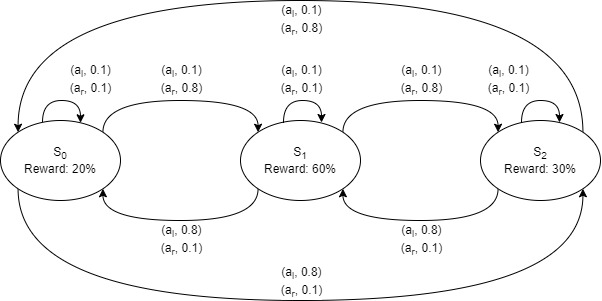

In [3]:
ACTION_COUNT = 2
STATE_COUNT = 3

In [4]:
# 80% chance of success, 10% land in other tile, 10% stay in place
MOVE_RND = 0.8
def transition_function(s, a, s_p):
    s_a = (s + (-1 if a == 0 else 1)) % STATE_COUNT # Left and right movement
    s_a = s_a if s_a >= 0 else s_a + STATE_COUNT
    
    if s_a == s_p:
        return MOVE_RND
    else:
        return round((1.0 - MOVE_RND) / (STATE_COUNT - 1), 1)

# Setup table to speedup computation
transition_table = np.zeros(shape=(STATE_COUNT, ACTION_COUNT, STATE_COUNT))
for s in range(STATE_COUNT):
    for a in range(ACTION_COUNT):
        for s_p in range(STATE_COUNT):
            transition_table[s,a,s_p] = transition_function(s,a,s_p)

# Test with action 0, ie: LEFT
transition_table[:,0,:]

array([[0.1, 0.1, 0.8],
       [0.8, 0.1, 0.1],
       [0.1, 0.8, 0.1]])

In [6]:
OBS_RND = 0.7 # 70% of observation success

observation_table = np.zeros((STATE_COUNT, ACTION_COUNT, STATE_COUNT))
for s_p in range(STATE_COUNT):
    for a in range(ACTION_COUNT):
        for o in range(STATE_COUNT):
            observation_table[s_p, a, o] = OBS_RND if s_p == o else (1.0 - OBS_RND) / (STATE_COUNT - 1)
          
observation_table[:,0,:]

array([[0.7 , 0.15, 0.15],
       [0.15, 0.7 , 0.15],
       [0.15, 0.15, 0.7 ]])

In [7]:
REWARD_PROBS = [0.2, 0.6, 0.3]

reward_table = np.zeros((STATE_COUNT, ACTION_COUNT, STATE_COUNT))
for s in range(STATE_COUNT):
    for a in range(ACTION_COUNT):
        for s_p in range(STATE_COUNT):
            reward_table[s,a,s_p] = REWARD_PROBS[s_p]
        
reward_table

array([[[0.2, 0.6, 0.3],
        [0.2, 0.6, 0.3]],

       [[0.2, 0.6, 0.3],
        [0.2, 0.6, 0.3]],

       [[0.2, 0.6, 0.3],
        [0.2, 0.6, 0.3]]])

In [8]:
states = ['s0','s1','s2']
actions = ['left', 'right']
observations = ['s0', 's1', 's2']

model = POMDP_Model(states, actions, observations, transition_table, reward_table, observation_table)

## Solving

In [9]:
solver = PBVI_Solver(model)

In [10]:
value_function = solver.solve(8,4)

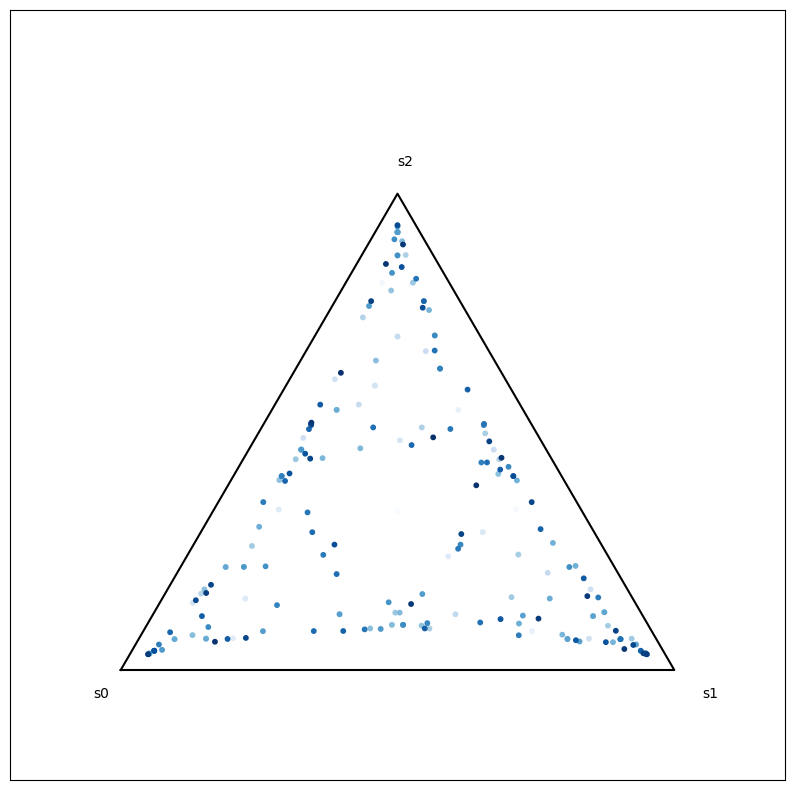

In [11]:
solver.plot_belief_set(10)

In [12]:
value_function

[AlphaVector([3.8640917 , 3.81569305, 4.01719614]),
 AlphaVector([3.9853484 , 3.88189536, 3.80084293]),
 AlphaVector([3.85589573, 3.81181405, 4.02270677]),
 AlphaVector([3.86157873, 3.81629963, 4.01736865]),
 AlphaVector([4.02275701, 3.85585562, 3.81147726]),
 AlphaVector([4.01812129, 3.86391502, 3.81309535]),
 AlphaVector([3.8560547 , 3.81121723, 4.0227517 ]),
 AlphaVector([3.86391502, 3.81309535, 4.01812129]),
 AlphaVector([3.97263353, 3.89368657, 3.72253692]),
 AlphaVector([3.86393637, 3.81531459, 4.01752963]),
 AlphaVector([3.85585562, 3.81147726, 4.02275701]),
 AlphaVector([3.85370941, 3.8146164 , 4.02209589]),
 AlphaVector([3.86379598, 3.81570891, 4.01739002]),
 AlphaVector([3.85370968, 3.81461604, 4.02209615]),
 AlphaVector([4.02270677, 3.85589573, 3.81181405]),
 AlphaVector([3.85590573, 3.81402887, 4.02211511]),
 AlphaVector([4.0179013 , 3.86420296, 3.81311257]),
 AlphaVector([3.98396121, 3.88222176, 3.80011759]),
 AlphaVector([3.97263353, 3.89368657, 3.72253692]),
 AlphaVector

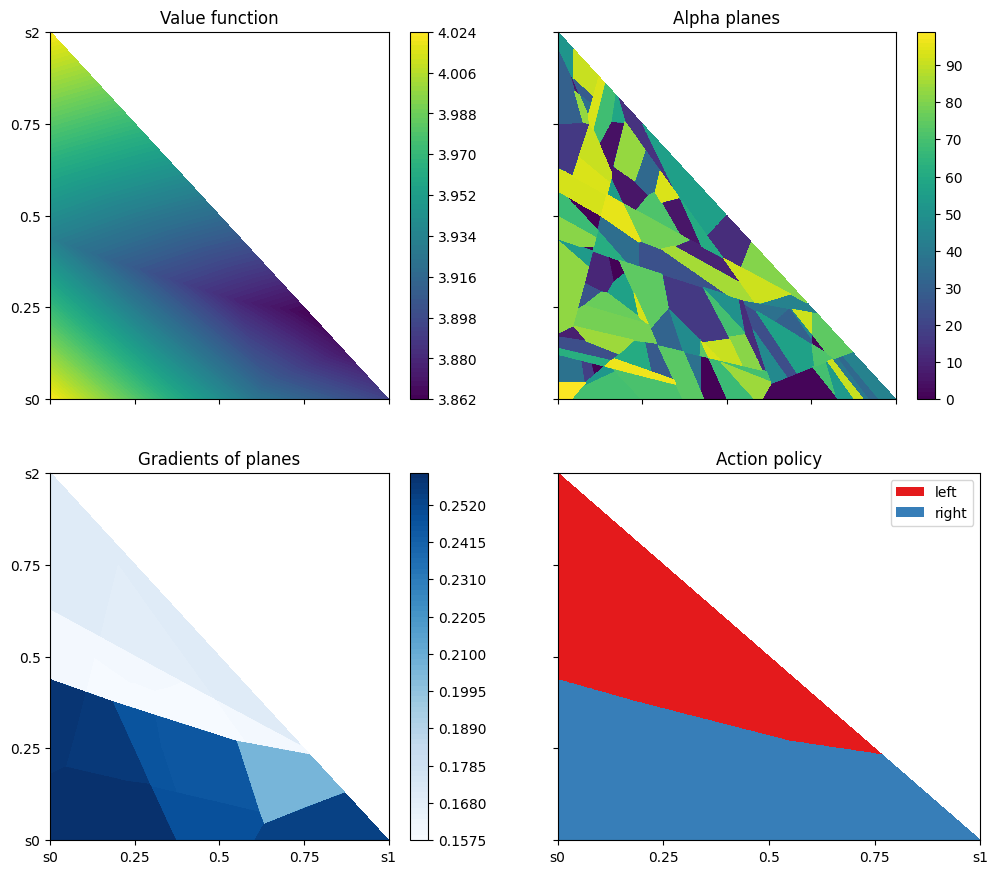

In [13]:
solver.plot_solution(3, plot_belief=False)

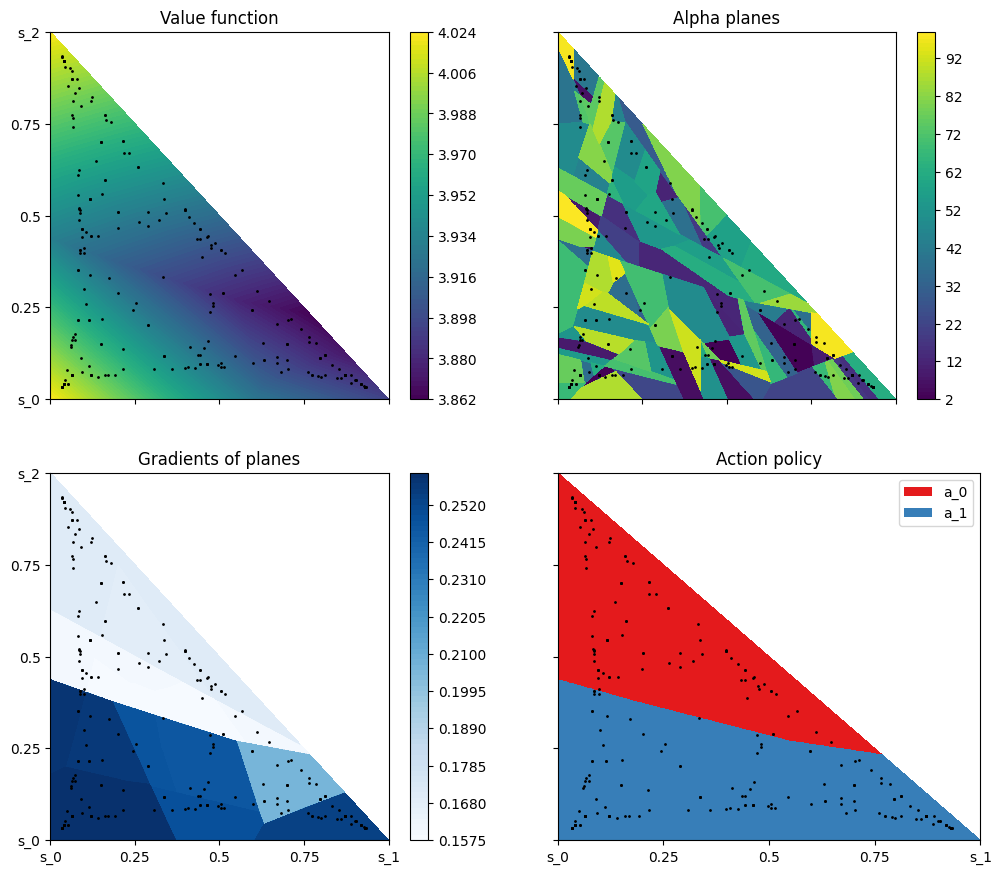

In [14]:
value_function.plot(3, belief_set=solver.explored_beliefs)